# Week 4 Assignment - Joseph Adams

## General Design

During initial investigations into how best to produce code for each of the tasks, it became clear that opening and reading of data from the files was a candidate for reuse.  Further investigation around the “report” identified that this area could also be re-used.<br>
<br>
To that end, the file_open() and create_report() functions are common to all tasks.  These common functions are identified and kept in the first code block immediately below.<br>
<br>
For the solutions to function correctly, the common functions (enclosed in the code block) need to be run before any of the task-specific codes afterward.<br>
<br>
With this reusability in mind, each task can be broadly broken down into the following steps:
- Loading of the data;
- Building a dictionary specific to the needs of the task;
- Sorting / calculating specific to the needs of the task;
- Output the data.

In addition to the issues above an issue was found when trying to read the data.  At the beginning of reading the data `\ufeff1` was appearing.  Some investigation was carried out and it was found that for files which had been encoded with the "UTF-8 as BOM" encoding method, if these were then read back using "UTF-8" then ufeff1 would appear.  Looking at both supplied CSV files in VS code it was found that both files did indeed have "UTF-8 with BOM" as the encoding.  Looking at the `file_open()` function in the common code below, it can be seen that the solution to this is to open the files using "utf-8-sig" encoding.

Below is a screenshot from VS Code of the bookloans.csv file showing the encoding in red.  The books.csv file also had the same encoding.
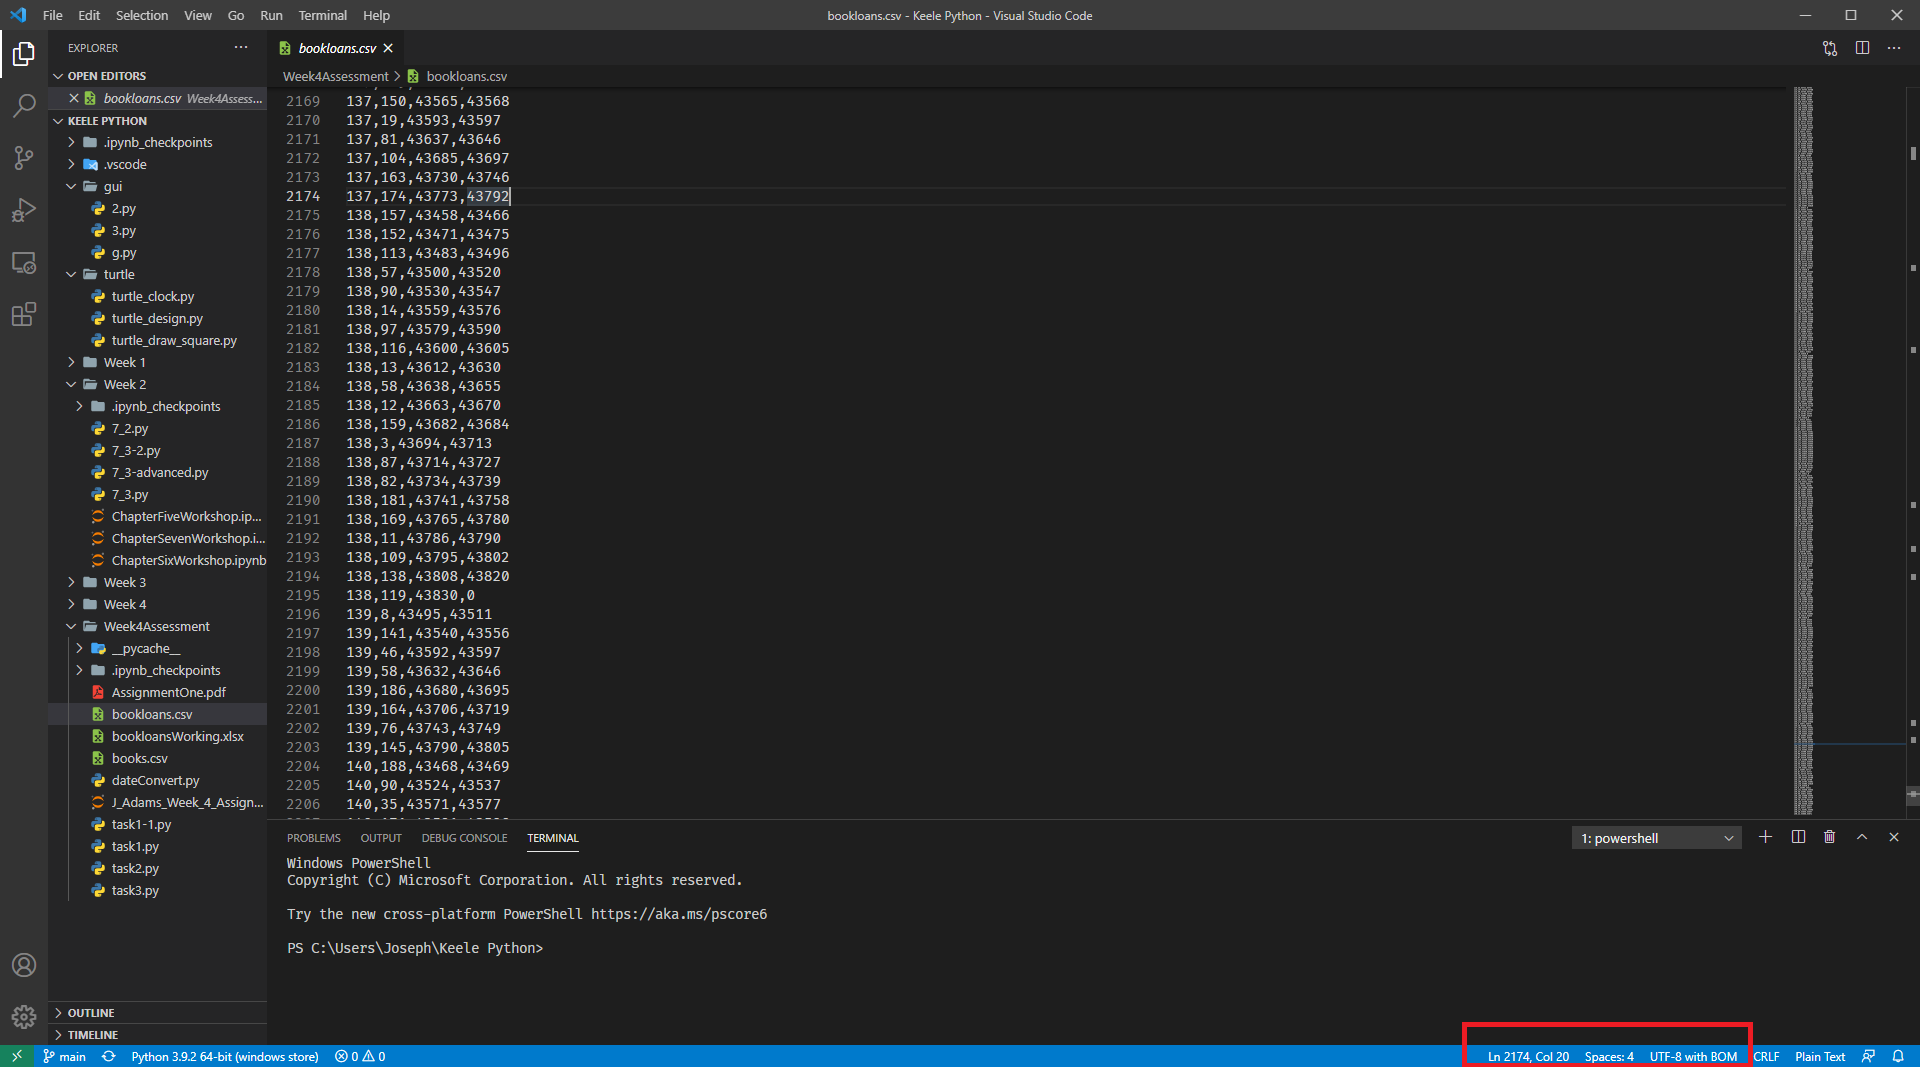


__NOTE__ the above is hard coded and is actual an ideal addition as a paramter in future

In addition to the encoding issue, the assignment question also identified 2 other issues:
- The loan start and loan end columns were using Excel epoch date formatting;
- Some rows in bookloans referred to books which were not present in the books file.

The aim of creating this notebook is to follow a standard approach for each task.  Specifically, each task shall have a code block with the task-specific code followed by a markdown block with any issues, assumptions, and general explanations.


## Common Code

In [3]:
import sys
import csv
import datetime

# csv file names
BOOKLOANSFILE = 'bookloans.csv'
BOOKSFILE = 'books.csv'
REPORTFILETASK_1 = 'Task_1_report.csv'
REPORTFILETASK2 = 'Task_2_report.csv'
REPORTFILETASK3 = 'Task_3_report.csv'


def open_file(file_in, skip_header=False):
    """Open a file and returns the data.

        Wraps a basic file open in a function to allow this
        to be reused.  When I was examining the books and
        bookloans files I noticed that when reading the
        files, I always ended up with a very random
        "\ufeff1" appearing right at the begning of the data
        from the file.  Further examination with VS Code
        showed that the encoding of the file was "utf-8 with
        BOM" and that this random sequence was a symptom.
        To corrrect this, the file had to be opened with
        "utf-8-sig" encoding.  I did consider if the
        encoding should also be made a parameter, but
        ultimately for these tasks kept this hard coded
        as both files share the same encoding.

        I also try to catch errors using a try/except
        block, I have one specific error "FileNotFoundError"
        and a generic catch all.  Error messages for both
        these occasions make use of string formatting to pass
        the fileIn parameter, which futher enhances re-usability.
        I fruther call sys.exit(1) which stops the execution
        and allows the OS to know there was a problem.

        I have checked the FileNotFound exception by passing
        in the name of a non-existing file.

        Keyword arguments:
            fileIn -- the file object whi chwill be opened
            skipHeader -- some files have "Headers" in the
            first row, if this is true we ignore these
            (defaults to False) Ultimatley, I never used
            this parameter

        Returns:
            data -- a list of tuples
    """
    # setup a variable to hold the data from the file
    data = ''
    try:
        with open(file_in, encoding='utf-8-sig', mode='r') as file:
            reader = csv.reader(file)
            if skip_header is True:
                # if skip_header is true, then skip to the next line
                next(reader, None)
            # make each row in the input file into a tuple and add
            # this to a list to be returned.
            data = [tuple(row) for row in reader]
    # handle file not found errors with a nice error message
    except FileNotFoundError:
        print('File {} does not exist.'.format(file_in))
        sys.exit(1)
    except:  # generic catch all error message
        print(
            'Trying to open {} failed.  No further information was available'
            .format(file_in))
        sys.exit(1)
    # return the data variable (the file contents)
    return data

def create_report(file_name, headers, content):
    """Creates a report file (currently a CSV)

    Keyword arguments:
        file_name -- the file we wish to create
        headers -- a list containing the header columns for the report
        content -- a list with the data to be populated in the file.
    """
    try:
        with open(file_name, 'a', newline="") as out_file:
            csvwriter = csv.writer(out_file)
            csvwriter.writerow(headers)
            csvwriter.writerows(content)
    except:
        print(
            'Trying to create {} failed.  No further information was available'
            .format(file_name)
        )
        sys.exit(1)

<font color='red'>__NOTE:__ The above code _MUST_ be run before any of the following code blocks..</font>
#### File Opening

This function wraps a standard Python file open in a try/except block. This has been written to catch FileNotFoundErrors and the error message has been written using placeholders to allow the file name being looked for to be shown in the error. Within this method, the contents of the file are read and returned as a list of tuples. 

**NOTE:** As mentioned in the task 1 notes above, one of the files had a header row, the other did not. Initial thoughts were that by adding a function argument to skip the header row, the function could be used for both the CSV files.  However, when reading data, often things could go out of sync and, in the interests of simplicity, the skip header parameter is never used and the header is dealt with in the specific task code.  This is the reason the skip header has been defaulted to False.

#### File Writing

This function wraps a standard Python CSV writer in a try / except block.  Only one exception has been identified here.

__Note__: The create file creates a file with the append action.  This is important for task2 when the genre and sub-genre reports will be joined together.

## Task_1

In [4]:
def convert_epoch_to_readable(date_in):
    """Convert Excel Epoch time to a sting.

    This strange epoch format was a challenge for me.  In order to check if
    the date was in 2019 (which was asked for in the question) the only
    way I could think was to convert this format to something "human"
    readable and then check for the year.  This function simply takes
    in the epoch date and passes out a human readable string.

    Note:
    Excel has a strange idea of epoch, as well a bug from Lotus notes,
    to convert the date to a readable format I used the following code,
    which was taken from the  Stackover Flow post referenced:

    Before using this function, I tested this by taking the date
    columns in the bookloans.csv and converting them to "date"
    format.
    I then checked that the dates returned by the function matched
    those of excel.  They did.

        Keyword arguments:
            dateIn -- the date (in excel epoch) format

        Returns:
            dateOut -- a date in string format (eg 12-01-1996)
    """
    # Mac and PC excel have different "start dates" - using a PC
    EXCEL_DATE_SYSTEM_PC = 1900

    dateOut = datetime.date(EXCEL_DATE_SYSTEM_PC, 1, 1) + datetime.timedelta(date_in-2)

    dateOut = dateOut.strftime("%d-%m-%Y")

    return dateOut


def contains_date(stringDate, dateToCheck):
    """Checks if a string contains another String.

    This takes two strings and returns a boolean if there is a substring match.
    This is marked as "containsDate" but it is essentially a substring matching
    function and could be renamed and still not loose any readability or
    functionality.

        Keyword arguments:
            stringDate -- a date in string format, in truth this could be ANY
            string.
            dateToCheck -- a part of the date to check, in truth this could be
            any string.
    """
    # basic substring matching here.  If we find the substring, return True,
    # else return False.
    if dateToCheck in stringDate:
        return True
    else:
        return False


def build_task1_details(loans):
    """Generate the content for the report.

    Keyword arguments:
        loans -- the list of data from the loans CSV file

    Returns:
        report_dict -- a dictionary (keyed on booknumber) containing
        times loaned in 2019, the title, the author
    """
    report_dict = {}
    for row in loans:
        # make things easier to reference
        book_number = row[0]
        book_number = int(book_number)

        # get the loaned date, convert this to an int and convert
        # to a readable string
        loaned_date_epoch = row[2]
        loaned_date_epoch = int(loaned_date_epoch)
        loaned_date_readable = convert_epoch_to_readable(loaned_date_epoch)

        # We will store the info on the books in a nested dictionary using the
        # book number as a key.
        # First ensure the book_number is not already present:
        if book_number not in report_dict:
            report_dict[book_number] = {}

        if book_number in report_dict:
            # we need to check if the book which is being loaned is present in
            # our cut down books.csv
            book_found = False

            # loop through the books
            for book in books:
                book_ref = book[0]
                # bit sucky, to keep code working I had to bring in the
                # headers. This makes sure we don't deal with the headers
                if book_ref != 'Number':
                    book_ref = int(book_ref)
                if book_ref == book_number:
                    book_found = True
            if book_found:
                # we have found the book - so add the author and title to
                # fields.
                book_title = books[book_number][1]
                book_author = books[book_number][2]
                if contains_date(loaned_date_readable, '2019'):
                    # if the book was loanded in 2019, get the number of
                    # times this has been out.
                    loaned_times = report_dict[book_number].get("timesOut2019")

                    # However, we may get a None type.  In this occasion,
                    # we can assume the bookNumber isn't in the dictionary,
                    # so set the loanedTimes as 1
                    if loaned_times is None:
                        loaned_times = 1
                    else:
                        loaned_times += 1
            else:
                # if the book wasn't found, then we blank out the name
                # and author
                book_title = ""
                book_author = ""

        else:
            # this is a new book
            report_dict[book_number]["timesOut2019"] = 1

        # add to fields only if the bookTitle is not an empty string
        if book_title != "":
            # we write this to reportDict
            report_dict[book_number]["timesOut2019"] = loaned_times
            report_dict[book_number]["title"] = book_title
            report_dict[book_number]["author"] = book_author
        else:
            # if the bookTitle is empty, then we also need to remove the
            # booknumber from the final report
            report_dict.pop(book_number)

    return report_dict


def sort_and_generate_task1_content(data_in):
    """Sorts  the dictionary which is passed in
    on the field timesOutIn2019 and then converts
    this to a list for use with the CSV writer function.

    This function also prints to the screen the report to provide
    the user with some indication that the task in underway.

    Keyword arguments:
        dataIn --  the dictionary which was built up in the
        buildTask1Details function.

    Returns:
        report_out -- a listed sorted on timesOutIn2019

    """
    report_out = []
    print(
        "{:<12} {:<60} {:<40} {:<10}".format
        ('Book Number', 'Title', 'Author', 'Times Loaned 2019')
        )
    for k, v in sorted(data_in.items(), key=lambda e: e[1]["timesOut2019"]):
        item = [k, v['title'], v['author'], v['timesOut2019']]
        report_out.append(item)
        print(
            "{:<12} {:<60} {:<40} {:<10}".format
            (k, v['title'], v['author'], v['timesOut2019'])
        )
    return report_out

# The headers for our report
report_headers = ['Book Number', 'Title', 'Author', 'Times Loaned 2019']

# Open the CSV files and assign them to variables
books = open_file(BOOKSFILE)
loans = open_file(BOOKLOANSFILE)

temp = build_task1_details(loans)
contents = sort_and_generate_task1_content(temp)
create_report(REPORTFILETASK_1, report_headers, contents)

Book Number  Title                                                        Author                                   Times Loaned 2019
13           Birth of a Theorem                                           Villani, Cedric                          1         
35           Surely You're Joking Mr Feynman                              Feynman, Richard                         2         
57           Textbook of Economic Theory                                  Stonier, Alfred                          2         
59           Learning OpenCV                                              Bradsky, Gary                            2         
67           Argumentative Indian, The                                    Sen, Amartya                             2         
108          Ashenden of The British Agent                                Maugham, William S                       2         
71           All the President's Men                                      Woodward, Bob                        

#### Task 1 Notes

The main flow of task 1 is the following:
```
# The headers for our report
report_headers = ['Book Number', 'Title', 'Author', 'Times Loaned 2019']

# Open the CSV files and assign them to variables
books = open_file(BOOKSFILE)
loans = open_file(BOOKLOANSFILE)

temp = build_task1_details(loans)
contents = sort_and_generate_task1_content(temp)
create_report(REPORTFILETASK_1, report_headers, contents)
```
As can be seen, use is made of the `file_open()` and `create_report()` functions identified in the "Common code section"

The first thing which is done (as is the case with the other tasks) is to load the data into variables to allow the data to be worked on.  This is done with:
```
books = open_file(BOOKSFILE)
loans = open_file(BOOKLOANSFILE)
```
It is worth noting that as the `file_open()` has an argument set to default=False then only one argument is needed.

Once the data has been loaded it is time to begin processing.  

As the question is looking for frequence of books loaned then most of this data is in the bookloans file, in this instance it is stored in the __loans__ list of tuples.

The function `build_task1_details()` is where the work will be done.

On entry into this function a new dictionary is created called `report_dict`.  This will also be the dictionary of dictionaries which is returned.

After creating the dictionary, the program will then go into a loop for each row in the bookloans file.
In order to make the readability a little easie the vaariable `book_number` is created. At this point, the epoch date is also assigned to a variable and the epoch format is converted to a "human readable" format using `convert_epoch_to_readable()`.  The `convert_epoch_to_readable()` function will be discussed at the end of this section.

Next the booknumber is checked to see if it exists in `report_dict`.  If it __is not__ present then a new _sub-dictionary_ is created using the booknumber as the "key."

The booknumber is then again checked to ensure that this is present in the `report_dict` and then the books file is looped over to search for the booknumber.  If the book is not found, then the title and author are set to empty strings.  If the book is found then the book title and autor are extracted.  

Next the loan is checked to see if it has happened in 2019.  If the loan was in 2019, then the number of times it was loaned is extracted and incremented by one, or set to 1 if this is the first time the book has been seen.

Finally, if the book has an empty title (which there are no books without a title) then this book is one which was not present in the books file and, as per the instrictions, can be discareded.  This is done by "popping" that sub-directory entry from `report_dict`

Once all the loans have been iterated over, the resulting dictionary of dictionaries is returned.  Each sub-dictonary will be of the format
```
bookNumber: {'author': <string> book author,
             'timesOut2019': <int> count of times loaned in 2019,
             'title': <string> title of the book}
```

##### Converting the Epoch date
The Excel epoch is converted to a readable format using the following function:
```
def convert_epoch_to_readable(date_in):

    # Mac and PC excel have different "start dates" - using a PC
    EXCEL_DATE_SYSTEM_PC = 1900

    dateOut = datetime.date(EXCEL_DATE_SYSTEM_PC, 1, 1) + datetime.timedelta(date_in-2)

    dateOut = dateOut.strftime("%d-%m-%Y")

    return dateOut
```
__Note__ During research for this conversion, it was noted there were "bugs" in the excel implemtation around 1900 and specifically that Excel often added 2 days to the count.  I have removed 2 days in my code and from spotchecking this function with values from the excel file, am getting the same results.

This function works by creating a new date object based on 1-1-1900 and then applying a difference(delta) of the epoch date(minus 2 for reason above) and then creating a new string from the resulting object in the form of day-month-year

##### Checking if the loan was in 2019
As the task asks to only deal with loans in 2019, the human readable value from the `convert_epoch_to_readable()` is checked using a basic string contains.  If the date contains 2019, then the loan happened in 2019.
```
def contains_date(stringDate, dateToCheck):
    # basic substring matching here.  If we find the substring, return True,
    # else return False.
    if dateToCheck in stringDate:
        return True
    else:
        return False
```

#### Sorting the data
Once `build_task1_details()` function has ran and returned a dictionary of dictionaries, the data now needs to be sorted.  At this point, the data from `build_task1_details()` is in order of book_number.  This is not what was asked for.  In order to sort this the function `sort_and_generate_task1_content()` is called.
```
def sort_and_generate_task1_content(data_in):
    report_out = []
    print(
        "{:<12} {:<60} {:<40} {:<10}".format
        ('Book Number', 'Title', 'Author', 'Times Loaned 2019')
        )
    for k, v in sorted(data_in.items(), key=lambda e: e[1]["timesOut2019"]):
        item = [k, v['title'], v['author'], v['timesOut2019']]
        report_out.append(item)
        print(
            "{:<12} {:<60} {:<40} {:<10}".format
            (k, v['title'], v['author'], v['timesOut2019'])
        )
    return report_out
```
This function will take the dictionary (of dictionaries) and will sort this on the element "timesOutIn2019" in increasing order.  The output of this is a list of lists.  As a side result of this process, the user will see the report being produced on screen.  In order to improve readability, string formatting is used to create a "tabular" output.  

#### Outputting the data
The assignment question was unclear on if on-screen was enough or if a CSV file was to be produced.  Given the references to CSV, the implication was that a CSV file should be produced.  
By this point, the user will already have the "on-screen" report, the CSV is just a duplicate of this.

This uses the common `create_report()` function.  Into this function, the `report_headers` list is passed as well as the filename ("Task_1_report.csv") and a list (of lists) which is the data.  The `create_report()` uses the Python CSV writer to write a single row of headers and then multiple rows (the data.)

In the Jupyter Notebook "serving from" location there should now be a "Task_1_report.csv" file which is a copy of the data on screen with BookNumber, Title, Author and times the book was loaned in 2019.

This concludes task 1.

## Task 2

In [5]:
def build_task2_details(loans):
    """Generate the content for the report.

    This function will build up a tuple containing 2 dictionaries.  One
    dictionary for genre and one for subgenre

    Keyword arguments:
        loans -- the list of data on the loans
    """
    report_dict = {}
    genre_dict = {}
    sub_genre_dict = {}
    genre_count = 0
    sub_genre_count = 0
    for row in loans:
        # get the booknumber from the bookloans list
        book_number = row[0]
        book_number = int(book_number)
        genre = ""  # books[book_number][3]
        sub_genre = ""  # books[book_number][4]

        for book in books:
            book_ref = book[0]
            # bit sucky, to keep code working I had to bring in the headers.
            if book_ref != 'Number':
                book_ref = int(book_ref)
                if book_ref == book_number:
                    book_found = True
                    genre = books[book_number][3]
                    sub_genre = books[book_number][4]
                    break
        if book_found:
            # here we cycle through the loans and update counters
            # in 2 dictionaries depending on the genre and subgenre
            if genre not in genre_dict:
                if genre != "":
                    genre_dict[genre] = {}
                    genre_count = 0
                    genre_dict[genre] = 1
            else:
                genre_count = genre_dict[genre]
                genre_count = int(genre_count)  # not needed as we control this
                genre_count += 1
                genre_dict[genre] = genre_count

            if sub_genre not in sub_genre_dict:
                if sub_genre != "":
                    sub_genre_dict[sub_genre] = {}
                    sub_genre_count = 0
                    sub_genre_dict[sub_genre] = 1
            else:
                sub_genre_count = sub_genre_dict[sub_genre]
                sub_genre_count = int(sub_genre_count)
                sub_genre_count += 1
                sub_genre_dict[sub_genre] = sub_genre_count

        report_dict = tuple([genre_dict, sub_genre_dict])

    return report_dict


def sort_and_generate_task2_content(data_in, task_num):
    """For task 2 this converts the dictionary to a list and sorts at
    the same time.

    Keyword arguments:
        dataIn --  the dictionary which was built up in the
        buildTask2Details function.
        sorts on the field timesOutIn2019 and then converts this to a list for use with the CSV writer import.
    """
    report_out = []
    if task_num == "Genre":
        print("{:<20} {:<10}".format('Genre', 'Count'))
        for k, v in sorted(data_in.items(), key=lambda e: e[1], reverse=True):
            item = [k, v]
            report_out.append(item)
            print("{:<20} {:<10}".format(k, v))
        return report_out
    elif task_num == "SubGenre":
        print("{:<20} {:<10}".format('Sub-Genre', 'Count'))
        for k, v in sorted(data_in.items(), key=lambda e: e[1], reverse=True):
            item = [k, v]
            report_out.append(item)
            print("{:<20} {:<10}".format(k, v))
        return report_out
    else:
        print("incorrect task number.  please try again")
        sys.exit(1)


books = open_file(BOOKSFILE)
loans = open_file(BOOKLOANSFILE)
temp = build_task2_details(loans)

# temp is a tulpe of two lists, we can split them int
(genre_list, sub_genre_list) = temp

genre_report_headers = ['Genre', 'Count']
sub_genre_report_headers = ['Sub-Genre', 'Count']

list_genre = sort_and_generate_task2_content(genre_list, "Genre")
list_sub_genre = sort_and_generate_task2_content(sub_genre_list, "SubGenre")

create_report(REPORTFILETASK2, genre_report_headers, list_genre)
create_report(REPORTFILETASK2, sub_genre_report_headers, list_sub_genre)

Genre                Count     
fiction              717       
nonfiction           591       
tech                 396       
science              153       
philosophy           101       
Sub-Genre            Count     
classic              362       
novel                355       
history              298       
data_science         150       
autobiography        138       
economics            129       
computer_science     94        
signal_processing    81        
mathematics          69        
misc                 64        
physics              55        
psychology           36        
education            28        
science              24        
trivia               23        
anthology            19        
poetry               15        
philosophy           15        
objectivism          3         


#### Task 2 Notes

The main flow of task 2 is the following:
```
books = open_file(BOOKSFILE)
loans = open_file(BOOKLOANSFILE)
temp = build_task2_details(loans)

# temp is a tulpe of two lists, we can split them int
(genre_list, sub_genre_list) = temp

genre_report_headers = ['Genre', 'Count']
sub_genre_report_headers = ['Sub-Genre', 'Count']

list_genre = sort_and_generate_task2_content(genre_list, "Genre")
list_sub_genre = sort_and_generate_task2_content(sub_genre_list, "SubGenre")

create_report(REPORTFILETASK2, genre_report_headers, list_genre)
create_report(REPORTFILETASK2, sub_genre_report_headers, list_sub_genre)
```

As in task 1, the `file_open()` function is used to load the data from both the books and the bookloans file.

This task again deals with the loans as the task is to work out the most popular genre and sub-genres. The bookloans contain the information on frequency and the books will be used in a "look up" capacity.

Once the data has been loaded, the function `build_task2_details()` is called.  

The first thing which happens is that 3 dictionaries are created:
`report_dict`, `genre_dict` and `sub_genre_dict`
Two counters are also created `genre_count` and `sub_genre_count`

Then the funcion starts to loop through the loans.

The booknumber is extracted and 2 placeholders for `genre` and `sub_genre` are defined.

Then the books are looped through.
This loop will check for the booknumber in the loan and the booknumber in the books file.  Once this is matched, the placeholders for `genre` and `sub_genre` are set.

After this, the code will check if the genre exists in the genre dictionary. If it __does not__ then a new sub-dictionary is created for that genre and the count is set to 1.  If the genre does exist, then the count is retrieved, incremented and set back in the sub dictionary.

The processes is _exactly_ the same for the sub-genre.

The code also prevents adding books which do not exist by checking for empty genre (and sub-genres)

#### Intermediate Step

The return from `build_task2_details()` is a tuple of 2 dictionaries.  These can be split apart simply using
```(genre_list, sub_genre_list) = temp```

These two dictionaries are then used in the sorting process.

#### Sorting the data

The assignment asks for "most popular genre and sub-genres" of books" so, it it makes sense to apply some form of sort to the data.  An assumption has been made here to have the __most popular__ items seen first.  

The sorting function is as follows:
```
def sort_and_generate_task2_content(data_in, task_num):
    report_out = []
    if task_num == "Genre":
        print("{:<20} {:<10}".format('Genre', 'Count'))
        for k, v in sorted(data_in.items(), key=lambda e: e[1], reverse=True):
            item = [k, v]
            report_out.append(item)
            print("{:<20} {:<10}".format(k, v))
        return report_out
    elif task_num == "SubGenre":
        print("{:<20} {:<10}".format('Sub-Genre', 'Count'))
        for k, v in sorted(data_in.items(), key=lambda e: e[1], reverse=True):
            item = [k, v]
            report_out.append(item)
            print("{:<20} {:<10}".format(k, v))
        return report_out
    else:
        print("incorrect task number.  please try again")
        sys.exit(1)
```
This function has been designed to be reusable for this task.  It takes in 2 arguments, `data_in` and `task_num`.
The `task_num` is actually a string value for either genre or SubGenre.  If neither of these values are found, then the function errors out.

The sorting is the same for both genre and sub-genre.  This is done in the `sort_and_generate_task2_content()` function.  The sort is reversed to ensure the highest values are at the top of the list.  As in task 1, this function will print out on screen so the user knows that the operation is being performed.  The function returns a list of lists, as before.  

Following this, the `create_report()` function is ran, passing in the appropriate filename, headers and the data.

In the Jupyter Notebook "serving from" location there should now be a "Task_2_report.csv" file which is a copy of the data on screen with Genre and Count, followed by SubGenre and Count.  Both lists being sorted in descending count order.

This concludes task 2.